In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.0.0'

In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

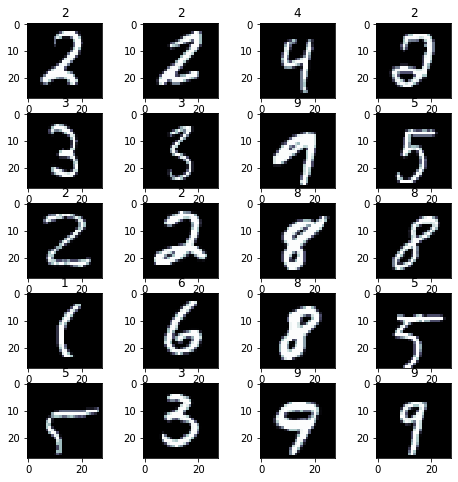

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

fig=plt.figure(figsize=(8, 8))
columns = 4; rows = 5
for i in range(1, columns*rows +1):
    r = random.randint(0,len(x_train))
    img = x_train[r]
    fig.add_subplot(rows, columns, i)
    plt.title(y_train[r])
    plt.imshow(img, cmap="bone")
plt.show()

In [8]:
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [10]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(7, activation='linear')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [14]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.RMSprop()

In [15]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [16]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)

In [17]:
@tf.function
def test_step(images, labels):
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)

In [ ]:
for epoch in range(5):
  train_loss.reset_states()
  test_loss.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        test_loss.result()))

In [21]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2769024   
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________
